## Error analysis - elongation and area
The purpose of this notebook is to analyse and visualise the erroneous height data in the sample using lazy dask routines. The notebook contains the following sections:
* Missing number analysis for whole sample
* Height data quality aggregated by country
* Height data quality aggregated by region

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dask.dataframe as dd
import dask_geopandas as dgp
import dask
import momepy as mp
import numpy as np

### Set up

In [2]:
parquet_dir = "./data/parquet/"

### Admininstrative areas
admin = pd.read_csv('./data/admin-codes-matches-v0.1.csv', dtype='str')
admin.drop('source', axis=1, inplace=True)

# Plot style
plt.style.use('../styles/matplotlib-stylesheets/pitayasmoothie-light.mplstyle')

## Elongated building distribution

In [3]:
def elong_func(df):
    return mp.Elongation(df).series

#### Dask routine

In [4]:
df = dgp.read_parquet(parquet_dir, index=False, columns=["id","height","geometry"])
df = df[df.height > 0]

elong_bins = np.arange(0, 1, 0.05)
df["elongation"] = df.map_partitions(elong_func, meta=pd.Series(dtype=pd.Float64Dtype()))
df["elong_cat"] = df.elongation.map_partitions(pd.cut, elong_bins, meta=pd.Series(dtype=pd.CategoricalDtype()))
df["height_small"] = df.height < 2.5

df_group = df.groupby(["elong_cat", "height_small"]).elong_cat.count()

### Post calculations

In [5]:
dfc = df_group.compute()
dfc.index = dfc.index.set_levels(pd.IntervalIndex(dfc.index.levels[0]).left , level=0)
dfc = dfc.rename("percentage")
dfc = dfc.reset_index()

small_sum = dfc.percentage[dfc.height_small].sum()
tall_sum =  dfc.percentage[~dfc.height_small].sum()
dfc.percentage = np.where(dfc.height_small, dfc.percentage / small_sum, dfc.percentage / tall_sum)
dfc = dfc.rename(columns={"height_small": "smaller than 2.5 m"})


#### Plot elongation distribution

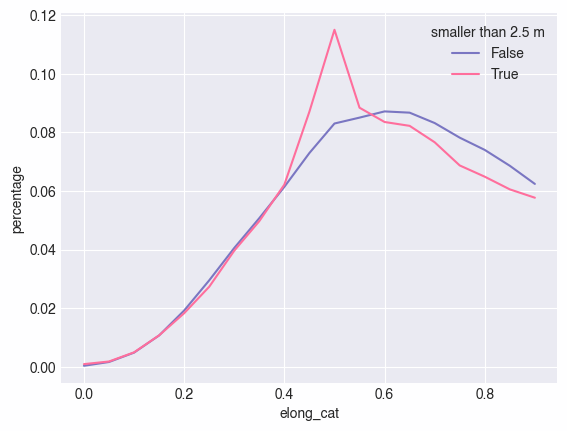

In [6]:

sns.lineplot(dfc, x="elong_cat", y="percentage", hue="smaller than 2.5 m");


Elongation does not correlate well with the height category, but we can still cut off the lower part of the distribution, which represent long, thin structures. elongation=1 is equivalent to a perfect circle, and rectangular building with sides ratio 1:8 would have an elongation 0.125. 

**I would suggest a lower cutoff of 0.125 or less for Elongation for all structures**

In [7]:
from shapely import box
mp.Elongation(gpd.GeoDataFrame(geometry=[box(0,0,1,8)])).series

0    0.125
dtype: float64

## Small areas

We now investigate whether small (inhabitable) areas co-correlate with small heights. 

#### Dask routine

In [8]:
df = dgp.read_parquet(parquet_dir, index=False, columns=["id","height","geometry"])
df = df[df.height > 0]

area_bins = np.arange(0, 200, 5)
df["A"] = df.area
df["area_cat"] = df.A.map_partitions(pd.cut, area_bins, meta=pd.Series(dtype=pd.CategoricalDtype()))
df["height_small"] = df.height < 2.5

df_group = df.groupby(["area_cat", "height_small"]).area_cat.count()

### Post calculations

In [9]:
dfc = df_group.compute()
dfc.index = dfc.index.set_levels(pd.IntervalIndex(dfc.index.levels[0]).left , level=0)
dfc = dfc.rename("percentage")
dfc = dfc.reset_index()

small_sum = dfc.percentage[dfc.height_small].sum()
tall_sum =  dfc.percentage[~dfc.height_small].sum()
dfc.percentage = np.where(dfc.height_small, dfc.percentage / small_sum, dfc.percentage / tall_sum)
dfc = dfc.rename(columns={"height_small": "smaller than 2.5 m"})


#### Plot elongation distribution

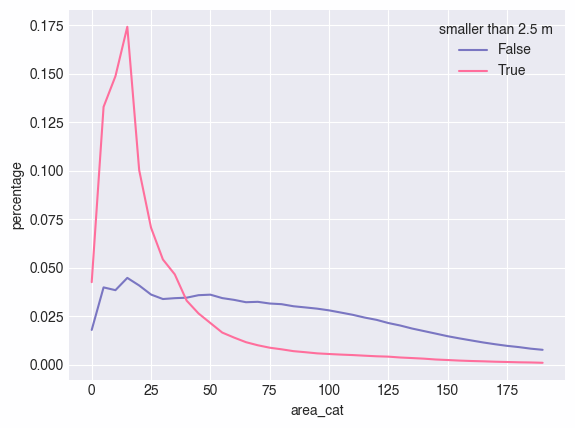

In [10]:
sns.lineplot(dfc, x="area_cat", y="percentage", hue="smaller than 2.5 m");

In [11]:
dfc.sort_values(by="percentage", ascending=False).head()

,area_cat,smaller than 2.5 m,percentage
7,15,True,0.174261
5,10,True,0.148801
3,5,True,0.132988
9,20,True,0.100389
11,25,True,0.070722


There is a very strong correlation between the heights category and area. Buildings smaller than 2.5 m tend to be very small indeed, with a peak around the minimal habitable area of 14-20 m2 for a one-person dwelling. This could be a suitable co-correlate for filtering out misidentifed structures.

**I would suggest a cutoff of 14 m2 for all structures.**

See: https://www.researchgate.net/publication/350969899_Housing_Spaces_in_Nine_European_Countries_A_Comparison_of_Dimensional_Requirements

In [12]:
## How many low height buildings remain once area and elongation cutoffs are applied?

df = dgp.read_parquet(parquet_dir, index=False, columns=["id","height","geometry"])
df["A"] = df.area
df["elongation"] = df.map_partitions(elong_func, meta=pd.Series(dtype=pd.Float64Dtype()))

df["H_filter"] = ((df.height < 2.5) & (df.height > 0))
df["A_filter"] = df.A < 14
df["E_filter"] = df.elongation <= 0.125

df = df[["H_filter","A_filter","E_filter"]]


Total = df.H_filter.count()
HF = df.H_filter.sum()
df = df[~df.A_filter]
AF = df.H_filter.sum()
df = df[~df.E_filter]
EF = df.H_filter.sum()

In [13]:
Total_c, HF_c, AF_c, EF_c = dask.compute(Total, HF, AF, EF)
print(Total_c, HF_c, AF_c, EF_c)

19840586 1176918 839755 835577


In [14]:
values = [HF_c/Total_c*100, AF_c/Total_c*100, EF_c/Total_c*100]
labels = ["Low height", "After area filter", "After elongation filter"]

pd.DataFrame({"filter": labels, "percentage": values})

,filter,percentage
0,Low height,5.931871
1,After area filter,4.232511
2,After elongation filter,4.211453
